In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime 
from sklearn import preprocessing

import torch
import torch.nn as nn
from torch.optim import Adam
import torch.utils.data as data_utils 

import cryptocompare

In [33]:
class NeuralNet(nn.Module):
    def __init__(self, 
                 activation_function = nn.ReLU,
                 optimizer = Adam,
                 dropout = 0.2
                ):
        super(NeuralNet, self).__init__()
        input_dim = 5
        hidden_dim = 100
        output_dim = 1
        self.lstm = nn.LSTM(input_dim, hidden_dim)
        self.layers =[nn.Dropout(p = dropout)]
        self.layers.append(nn.Linear(hidden_dim, output_dim))
        self.layers = nn.Sequential(*self.layers)


    def forward(self, x):
        out, _ = self.lstm(x.view(len(x), 1 , -1))
        out = self.layers(out.view(len(x), -1))
        return out

In [34]:
data = cryptocompare.get_historical_price_day('BTC', 'EUR', limit=2000, exchange='CCCAGG', toTs=datetime.now())
df = pd.DataFrame.from_dict(data)
df = df.set_index('time')
df.index = pd.to_datetime(df.index, unit='s')

df.head()


,high,low,open,volumefrom,volumeto,close,conversionType,conversionSymbol
time,,,,,,,,
2015-11-10,354.07,304.66,352.13,18512.46,6167808.23,315.33,direct,
2015-11-11,319.04,277.11,315.33,25162.20,7414887.02,286.21,direct,
2015-11-12,322.89,285.20,286.21,16081.06,4951233.18,309.10,direct,
2015-11-13,318.11,301.81,309.10,6918.45,2152774.19,312.61,direct,
2015-11-14,315.94,305.17,312.61,4047.36,1254658.50,309.63,direct,


In [35]:
df = df.iloc[:, :6]
df.head()

,high,low,open,volumefrom,volumeto,close
time,,,,,,
2015-11-10,354.07,304.66,352.13,18512.46,6167808.23,315.33
2015-11-11,319.04,277.11,315.33,25162.20,7414887.02,286.21
2015-11-12,322.89,285.20,286.21,16081.06,4951233.18,309.10
2015-11-13,318.11,301.81,309.10,6918.45,2152774.19,312.61
2015-11-14,315.94,305.17,312.61,4047.36,1254658.50,309.63


In [36]:
def split_data(data, train_prop=0.8):
    train_data = df.iloc[:int(train_prop * len(data))]
    test_data = df.iloc[int(train_prop * len(data)):]
    return train_data, test_data

train_data, test_data = split_data(df, train_prop=0.8)


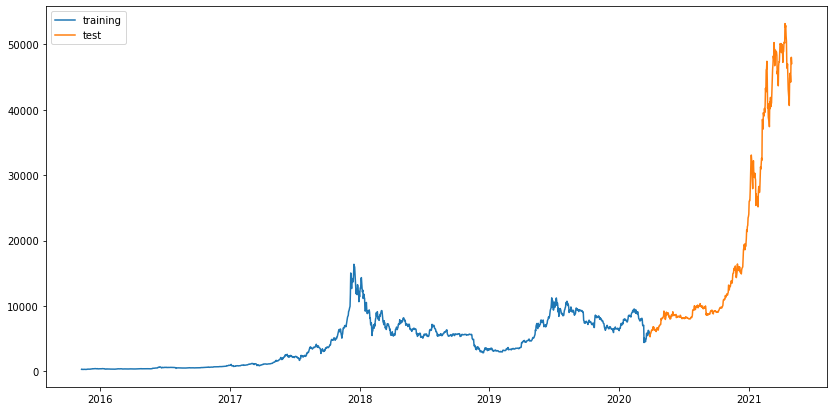

In [37]:

def plot_curves(to_plot, labels, title='', x_label='', y_label=''):
    fig, ax = plt.subplots(1, figsize=(14, 7))
    for i in range(len(to_plot)):
        ax.plot(to_plot[i], label=labels[i])
    
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(title)
    ax.legend()
plot_curves([train_data['close'], test_data['close']], ['training', 'test'], title='')

In [38]:
def normalize_data(dataframe):
    x = dataframe.values
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    normalized_df = pd.DataFrame(x_scaled, columns = dataframe.columns)
    return normalized_df

def denormalize_data(real_df, normalized_df):
    x = real_df.values
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    new_x = x_scaled* (min_max_scaler.data_max_-min_max_scaler.data_min_) + min_max_scaler.data_min_
    return pd.DataFrame(new_x, columns = df.columns)
    

    

In [39]:
train_data.head()

,high,low,open,volumefrom,volumeto,close
time,,,,,,
2015-11-10,354.07,304.66,352.13,18512.46,6167808.23,315.33
2015-11-11,319.04,277.11,315.33,25162.20,7414887.02,286.21
2015-11-12,322.89,285.20,286.21,16081.06,4951233.18,309.10
2015-11-13,318.11,301.81,309.10,6918.45,2152774.19,312.61
2015-11-14,315.94,305.17,312.61,4047.36,1254658.50,309.63


In [40]:
train_normalized = normalize_data(train_data)
train_normalized.head()

,high,low,open,volumefrom,volumeto,close
0,0.003004,0.001779,0.004097,0.161394,0.004066,0.001810
1,0.000863,0.000000,0.001810,0.226121,0.005061,0.000000
2,0.001099,0.000522,0.000000,0.137728,0.003095,0.001423
3,0.000807,0.001595,0.001423,0.048541,0.000863,0.001641
4,0.000674,0.001812,0.001641,0.020595,0.000146,0.001456


In [41]:
denormalize_data(train_data, train_normalized).head()

,high,low,open,volumefrom,volumeto,close
0,354.07,304.66,352.13,18512.46,6167808.23,315.33
1,319.04,277.11,315.33,25162.20,7414887.02,286.21
2,322.89,285.20,286.21,16081.06,4951233.18,309.10
3,318.11,301.81,309.10,6918.45,2152774.19,312.61
4,315.94,305.17,312.61,4047.36,1254658.50,309.63


In [42]:
train_target_tensor = torch.tensor(train_normalized['close'].values.astype(np.float64))
train_data_tensor = torch.tensor(train_normalized.drop('close', axis = 1).values) 
train_tensor = data_utils.TensorDataset(train_data_tensor, train_target_tensor) 
train_loader = data_utils.DataLoader(dataset = train_tensor, batch_size = 32, shuffle = True)


In [43]:
from tqdm import tqdm


model = NeuralNet()

EPOCHS = 1000

target = pd.DataFrame(data = train_normalized['close'])


criterion = nn.MSELoss()
optimizer = Adam(model.parameters(), lr=0.0001)

losses = []
for epoch in range(EPOCHS):
    epoch_loss = 0
    for bidx, batch in tqdm(enumerate(train_loader)):
        X, Y = batch
        model.zero_grad()
        loss = 0
        for i in range(len(X)):
            x, y = X[i], Y[i]
            x = x.view(-1, len(x))
            
            #Forward Pass
            y_hat = model(x.float())
            
            #Loss
            loss += criterion(y.float(), y_hat.float())
        
        #Backward pass
        loss.backward()
        
        #Parameters optimization
        optimizer.step()
        
        epoch_loss += float(loss)
        
    losses.append(epoch_loss)
    print("Epoch ", epoch, ": ", epoch_loss)
        
        
  

0it [00:00, ?it/s]/home/jbouhadoun/anaconda3/envs/nlp/lib/python3.8/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
50it [00:01, 48.37it/s]
5it [00:00, 48.43it/s]

Epoch  0 :  226.52152824401855


50it [00:01, 48.63it/s]
5it [00:00, 49.03it/s]

Epoch  1 :  191.20968961715698


50it [00:00, 50.09it/s]
6it [00:00, 50.46it/s]

Epoch  2 :  159.25230395793915


50it [00:01, 49.33it/s]
5it [00:00, 46.33it/s]

Epoch  3 :  128.8826652765274


50it [00:01, 49.58it/s]
5it [00:00, 43.87it/s]

Epoch  4 :  101.50862061977386


50it [00:01, 48.71it/s]
5it [00:00, 49.22it/s]

Epoch  5 :  78.01999294757843


50it [00:01, 49.51it/s]
5it [00:00, 49.99it/s]

Epoch  6 :  59.079518496990204


50it [00:01, 49.85it/s]
5it [00:00, 48.93it/s]

Epoch  7 :  45.07774057984352


50it [00:01, 48.29it/s]
5it [00:00, 49.43it/s]

Epoch  8 :  35.63831841945648


50it [00:00, 50.10it/s]
5it [00:00, 48.13it/s]

Epoch  9 :  30.121492594480515


50it [00:01, 49.50it/s]
5it [00:00, 49.54it/s]

Epoch  10 :  25.96685352921486


50it [00:01, 49.52it/s]
5it [00:00, 47.84it/s]

Epoch  11 :  23.719286233186722


50it [00:01, 49.46it/s]
5it [00:00, 50.00it/s]

Epoch  12 :  21.94456622004509


50it [00:00, 50.10it/s]
5it [00:00, 47.23it/s]

Epoch  13 :  19.78970444202423


50it [00:00, 50.03it/s]
5it [00:00, 48.09it/s]

Epoch  14 :  18.273293033242226


50it [00:00, 50.19it/s]
5it [00:00, 49.29it/s]

Epoch  15 :  16.689379051327705


50it [00:01, 49.94it/s]
5it [00:00, 48.23it/s]

Epoch  16 :  14.836921900510788


50it [00:00, 50.02it/s]
5it [00:00, 48.60it/s]

Epoch  17 :  13.519907653331757


50it [00:00, 50.06it/s]
5it [00:00, 48.13it/s]

Epoch  18 :  12.149517953395844


50it [00:00, 50.26it/s]
5it [00:00, 49.38it/s]

Epoch  19 :  10.966824911534786


50it [00:00, 50.28it/s]
6it [00:00, 50.48it/s]

Epoch  20 :  9.397314801812172


50it [00:01, 49.78it/s]
5it [00:00, 45.97it/s]

Epoch  21 :  8.332859948277473


50it [00:01, 48.56it/s]
5it [00:00, 48.38it/s]

Epoch  22 :  7.296455062925816


50it [00:01, 49.12it/s]
5it [00:00, 49.18it/s]

Epoch  23 :  6.21964555978775


50it [00:01, 49.09it/s]
5it [00:00, 47.48it/s]

Epoch  24 :  5.313509956002235


50it [00:01, 49.17it/s]
5it [00:00, 47.43it/s]

Epoch  25 :  4.721532680094242


50it [00:00, 50.64it/s]
6it [00:00, 50.60it/s]

Epoch  26 :  4.03903766348958


50it [00:01, 49.53it/s]
6it [00:00, 50.35it/s]

Epoch  27 :  3.503773007541895


50it [00:00, 50.38it/s]
5it [00:00, 48.56it/s]

Epoch  28 :  3.0472658686339855


50it [00:01, 49.81it/s]
6it [00:00, 50.60it/s]

Epoch  29 :  2.8285881020128727


50it [00:01, 48.63it/s]
5it [00:00, 44.04it/s]

Epoch  30 :  2.3729605693370104


50it [00:01, 49.12it/s]
5it [00:00, 47.73it/s]

Epoch  31 :  2.4232489969581366


50it [00:01, 49.10it/s]
5it [00:00, 49.44it/s]

Epoch  32 :  2.3625641111284494


50it [00:01, 49.47it/s]
5it [00:00, 48.74it/s]

Epoch  33 :  2.042625860311091


50it [00:01, 49.66it/s]
5it [00:00, 46.11it/s]

Epoch  34 :  1.827274201437831


50it [00:01, 49.00it/s]
5it [00:00, 47.47it/s]

Epoch  35 :  1.6945314519107342


50it [00:01, 49.26it/s]
5it [00:00, 48.32it/s]

Epoch  36 :  1.830508471466601


50it [00:01, 49.58it/s]
5it [00:00, 48.46it/s]

Epoch  37 :  1.747026139870286


50it [00:01, 49.31it/s]
5it [00:00, 49.79it/s]

Epoch  38 :  1.5290490901097655


50it [00:01, 49.98it/s]
5it [00:00, 44.23it/s]

Epoch  39 :  1.5277908649295568


50it [00:01, 49.09it/s]
5it [00:00, 46.31it/s]

Epoch  40 :  1.4973902814090252


50it [00:01, 48.23it/s]
5it [00:00, 43.74it/s]

Epoch  41 :  1.4828677894547582


50it [00:01, 49.47it/s]
6it [00:00, 50.71it/s]

Epoch  42 :  1.48485410772264


50it [00:01, 49.96it/s]
5it [00:00, 48.57it/s]

Epoch  43 :  1.4727997183799744


50it [00:00, 50.25it/s]
5it [00:00, 47.45it/s]

Epoch  44 :  1.3966019470244646


50it [00:00, 50.11it/s]
5it [00:00, 49.76it/s]

Epoch  45 :  1.3311977023258805


50it [00:00, 50.37it/s]
5it [00:00, 49.19it/s]

Epoch  46 :  1.470929958857596


50it [00:01, 49.84it/s]
5it [00:00, 48.33it/s]

Epoch  47 :  1.3382502254098654


50it [00:01, 49.21it/s]
5it [00:00, 47.40it/s]

Epoch  48 :  1.411564382724464


50it [00:01, 49.40it/s]
5it [00:00, 49.79it/s]

Epoch  49 :  1.3357353955507278


50it [00:00, 50.63it/s]
5it [00:00, 48.21it/s]

Epoch  50 :  1.2344321738928556


50it [00:01, 49.43it/s]
5it [00:00, 49.48it/s]

Epoch  51 :  1.284815402701497


50it [00:01, 49.46it/s]
5it [00:00, 48.75it/s]

Epoch  52 :  1.297712054103613


50it [00:01, 49.32it/s]
5it [00:00, 48.19it/s]

Epoch  53 :  1.186412014067173


50it [00:01, 49.35it/s]
5it [00:00, 49.12it/s]

Epoch  54 :  1.3216044278815389


50it [00:01, 49.05it/s]
4it [00:00, 39.23it/s]

Epoch  55 :  1.2478672247380018


50it [00:01, 48.48it/s]
5it [00:00, 47.75it/s]

Epoch  56 :  1.3229039460420609


50it [00:01, 48.92it/s]
5it [00:00, 46.63it/s]

Epoch  57 :  1.2643255414441228


50it [00:01, 48.71it/s]
5it [00:00, 45.10it/s]

Epoch  58 :  1.3551448285579681


50it [00:01, 48.51it/s]
5it [00:00, 49.09it/s]

Epoch  59 :  1.1607281658798456


50it [00:00, 50.18it/s]
5it [00:00, 47.65it/s]

Epoch  60 :  1.20278044603765


50it [00:01, 47.24it/s]
6it [00:00, 50.40it/s]

Epoch  61 :  1.2451204424723983


50it [00:00, 50.57it/s]
5it [00:00, 49.18it/s]

Epoch  62 :  1.1570884063839912


50it [00:00, 50.05it/s]
5it [00:00, 47.02it/s]

Epoch  63 :  1.1805405989289284


50it [00:00, 50.11it/s]
5it [00:00, 49.97it/s]

Epoch  64 :  1.1269163955003023


50it [00:00, 50.50it/s]
5it [00:00, 49.53it/s]

Epoch  65 :  1.07494329335168


50it [00:01, 49.20it/s]
5it [00:00, 49.63it/s]

Epoch  66 :  1.2537825470790267


50it [00:01, 49.41it/s]
5it [00:00, 47.88it/s]

Epoch  67 :  1.093986514955759


50it [00:01, 49.59it/s]
5it [00:00, 48.08it/s]

Epoch  68 :  1.1138027012348175


50it [00:01, 49.44it/s]
5it [00:00, 47.14it/s]

Epoch  69 :  1.17426732275635


50it [00:01, 48.15it/s]
5it [00:00, 44.56it/s]

Epoch  70 :  1.2121165385469794


50it [00:01, 49.23it/s]
5it [00:00, 49.18it/s]

Epoch  71 :  1.1824163626879454


50it [00:01, 49.88it/s]
5it [00:00, 49.86it/s]

Epoch  72 :  1.1634836634621024


50it [00:01, 49.47it/s]
5it [00:00, 49.24it/s]

Epoch  73 :  1.1207101503387094


50it [00:01, 49.45it/s]
5it [00:00, 49.05it/s]

Epoch  74 :  1.224992339964956


50it [00:01, 49.69it/s]
5it [00:00, 49.52it/s]

Epoch  75 :  1.1323181968182325


50it [00:01, 49.71it/s]
5it [00:00, 48.96it/s]

Epoch  76 :  1.0522268619388342


50it [00:01, 49.82it/s]
5it [00:00, 49.01it/s]

Epoch  77 :  1.1429095650091767


50it [00:01, 49.84it/s]
5it [00:00, 49.80it/s]

Epoch  78 :  1.1145227989181876


50it [00:01, 49.46it/s]
5it [00:00, 46.17it/s]

Epoch  79 :  0.9725634921342134


50it [00:01, 49.21it/s]
5it [00:00, 44.52it/s]

Epoch  80 :  1.0904105715453625


50it [00:01, 49.41it/s]
5it [00:00, 49.23it/s]

Epoch  81 :  1.0655667250975966


50it [00:01, 49.51it/s]
5it [00:00, 47.78it/s]

Epoch  82 :  1.0022759353742003


50it [00:01, 49.59it/s]
5it [00:00, 48.64it/s]

Epoch  83 :  1.196738968603313


50it [00:01, 49.38it/s]
5it [00:00, 49.28it/s]

Epoch  84 :  1.1066051116213202


50it [00:00, 50.09it/s]
5it [00:00, 49.99it/s]

Epoch  85 :  0.9947033212520182


50it [00:00, 50.13it/s]
5it [00:00, 49.49it/s]

Epoch  86 :  1.1591862780041993


50it [00:01, 49.35it/s]
5it [00:00, 49.17it/s]

Epoch  87 :  1.062429147772491


50it [00:01, 49.21it/s]
5it [00:00, 46.67it/s]

Epoch  88 :  0.9754430959001184


50it [00:01, 49.60it/s]
6it [00:00, 50.57it/s]

Epoch  89 :  1.0416073352098465


50it [00:00, 50.36it/s]
6it [00:00, 50.55it/s]

Epoch  90 :  1.034252523444593


50it [00:00, 50.42it/s]
5it [00:00, 49.27it/s]

Epoch  91 :  1.0384650365449488


50it [00:00, 50.12it/s]
5it [00:00, 49.54it/s]

Epoch  92 :  0.983826638199389


50it [00:01, 49.85it/s]
6it [00:00, 50.97it/s]

Epoch  93 :  1.0810855189338326


50it [00:00, 50.07it/s]
5it [00:00, 48.23it/s]

Epoch  94 :  1.0033685564994812


50it [00:01, 49.88it/s]
6it [00:00, 50.81it/s]

Epoch  95 :  0.9644667506217957


50it [00:00, 50.02it/s]
5it [00:00, 43.66it/s]

Epoch  96 :  0.9952208772301674


50it [00:01, 48.15it/s]
5it [00:00, 49.83it/s]

Epoch  97 :  0.9563701115548611


50it [00:00, 50.01it/s]
5it [00:00, 43.30it/s]

Epoch  98 :  0.9917808859609067


50it [00:01, 49.43it/s]
5it [00:00, 49.21it/s]

Epoch  99 :  0.9803549405187368


50it [00:01, 49.81it/s]
6it [00:00, 50.36it/s]

Epoch  100 :  0.9703003810718656


50it [00:00, 50.19it/s]
5it [00:00, 43.10it/s]

Epoch  101 :  0.9943444617092609


50it [00:01, 48.58it/s]
5it [00:00, 48.87it/s]

Epoch  102 :  0.994350400287658


50it [00:01, 49.58it/s]
5it [00:00, 49.82it/s]

Epoch  103 :  0.938644596375525


50it [00:00, 50.56it/s]
6it [00:00, 49.91it/s]

Epoch  104 :  0.9195931176654994


50it [00:00, 50.10it/s]
5it [00:00, 47.03it/s]

Epoch  105 :  0.8976736683398485


50it [00:01, 49.89it/s]
6it [00:00, 50.74it/s]

Epoch  106 :  0.934625600464642


50it [00:01, 49.76it/s]
6it [00:00, 50.30it/s]

Epoch  107 :  0.9533915976062417


50it [00:01, 49.94it/s]
5it [00:00, 49.06it/s]

Epoch  108 :  0.9410846615210176


50it [00:00, 50.08it/s]
6it [00:00, 50.16it/s]

Epoch  109 :  0.9493259778246284


50it [00:00, 50.26it/s]
5it [00:00, 43.82it/s]

Epoch  110 :  0.8982426491566002


50it [00:01, 49.35it/s]
5it [00:00, 48.09it/s]

Epoch  111 :  0.8695171331055462


50it [00:01, 49.44it/s]
5it [00:00, 46.49it/s]

Epoch  112 :  0.9520315346308053


50it [00:01, 48.97it/s]
5it [00:00, 48.31it/s]

Epoch  113 :  0.809911176096648


50it [00:01, 49.73it/s]
5it [00:00, 49.93it/s]

Epoch  114 :  0.9491686248220503


50it [00:00, 50.33it/s]
5it [00:00, 49.42it/s]

Epoch  115 :  0.8831863729283214


50it [00:00, 50.31it/s]
6it [00:00, 50.52it/s]

Epoch  116 :  0.8557540704496205


50it [00:00, 50.33it/s]
5it [00:00, 47.05it/s]

Epoch  117 :  0.9555254555307329


50it [00:01, 49.59it/s]
5it [00:00, 48.94it/s]

Epoch  118 :  0.9222695068456233


50it [00:00, 50.57it/s]
5it [00:00, 48.76it/s]

Epoch  119 :  0.9474811912514269


50it [00:00, 50.16it/s]
5it [00:00, 48.58it/s]

Epoch  120 :  0.8457196885719895


50it [00:00, 50.42it/s]
5it [00:00, 49.35it/s]

Epoch  121 :  0.9873150181956589


50it [00:01, 49.10it/s]
5it [00:00, 48.86it/s]

Epoch  122 :  0.8937028651125729


50it [00:00, 50.10it/s]
5it [00:00, 49.34it/s]

Epoch  123 :  0.7973087434656918


50it [00:00, 50.39it/s]
5it [00:00, 49.79it/s]

Epoch  124 :  0.7909450470469892


50it [00:00, 50.04it/s]
5it [00:00, 42.85it/s]

Epoch  125 :  0.8640725300647318


50it [00:01, 49.39it/s]
5it [00:00, 45.32it/s]

Epoch  126 :  0.7878418425098062


50it [00:01, 48.18it/s]
4it [00:00, 38.69it/s]

Epoch  127 :  0.776277722325176


50it [00:01, 45.90it/s]
5it [00:00, 49.16it/s]

Epoch  128 :  0.9000073932111263


50it [00:01, 48.93it/s]
6it [00:00, 50.61it/s]

Epoch  129 :  0.7739981766790152


50it [00:00, 50.29it/s]
6it [00:00, 50.19it/s]

Epoch  130 :  0.875819880515337


50it [00:00, 50.72it/s]
5it [00:00, 48.79it/s]

Epoch  131 :  0.8985183350741863


50it [00:00, 50.39it/s]
5it [00:00, 48.91it/s]

Epoch  132 :  0.8440468218177557


50it [00:00, 50.38it/s]
5it [00:00, 49.45it/s]

Epoch  133 :  0.8699459973722696


50it [00:00, 50.25it/s]
5it [00:00, 49.90it/s]

Epoch  134 :  0.8435612563043833


50it [00:01, 47.66it/s]
5it [00:00, 48.36it/s]

Epoch  135 :  0.8333730213344097


50it [00:01, 49.90it/s]
5it [00:00, 49.04it/s]

Epoch  136 :  0.7603533370420337


50it [00:01, 49.17it/s]
6it [00:00, 50.45it/s]

Epoch  137 :  0.8298355676233768


50it [00:01, 49.57it/s]
5it [00:00, 48.45it/s]

Epoch  138 :  0.7969932914711535


50it [00:01, 49.97it/s]
5it [00:00, 46.81it/s]

Epoch  139 :  0.8542603310197592


50it [00:01, 49.35it/s]
5it [00:00, 49.37it/s]

Epoch  140 :  0.7525010923855007


50it [00:01, 49.16it/s]
5it [00:00, 49.41it/s]

Epoch  141 :  0.8163597206585109


50it [00:01, 49.56it/s]
6it [00:00, 50.59it/s]

Epoch  142 :  0.8261599293909967


50it [00:01, 48.88it/s]
5it [00:00, 48.02it/s]

Epoch  143 :  0.7237054817378521


50it [00:01, 48.99it/s]
5it [00:00, 47.21it/s]

Epoch  144 :  0.7691261195577681


50it [00:01, 49.09it/s]
6it [00:00, 51.36it/s]

Epoch  145 :  0.7448747288435698


50it [00:00, 50.55it/s]
5it [00:00, 49.39it/s]

Epoch  146 :  0.6981457681395113


50it [00:01, 49.81it/s]
6it [00:00, 50.35it/s]

Epoch  147 :  0.7913470482453704


50it [00:00, 50.60it/s]
6it [00:00, 50.43it/s]

Epoch  148 :  0.7494566538371146


50it [00:00, 50.26it/s]
5it [00:00, 47.60it/s]

Epoch  149 :  0.6801443276926875


50it [00:01, 49.77it/s]
5it [00:00, 49.98it/s]

Epoch  150 :  0.7099289880134165


50it [00:00, 50.30it/s]
5it [00:00, 49.06it/s]

Epoch  151 :  0.7460209038108587


50it [00:00, 50.08it/s]
5it [00:00, 48.68it/s]

Epoch  152 :  0.7363566686399281


50it [00:00, 50.35it/s]
5it [00:00, 43.21it/s]

Epoch  153 :  0.7487378870137036


50it [00:01, 49.30it/s]
6it [00:00, 50.48it/s]

Epoch  154 :  0.7441338184289634


50it [00:01, 49.95it/s]
6it [00:00, 50.51it/s]

Epoch  155 :  0.7055566641502082


50it [00:00, 50.26it/s]
5it [00:00, 49.18it/s]

Epoch  156 :  0.7274704920127988


50it [00:01, 49.25it/s]
5it [00:00, 49.22it/s]

Epoch  157 :  0.734683099668473


50it [00:01, 49.80it/s]
5it [00:00, 47.46it/s]

Epoch  158 :  0.768690608208999


50it [00:00, 50.09it/s]
5it [00:00, 48.06it/s]

Epoch  159 :  0.7622921667061746


50it [00:01, 49.33it/s]
5it [00:00, 46.92it/s]

Epoch  160 :  0.739954347955063


50it [00:01, 48.33it/s]
5it [00:00, 45.80it/s]

Epoch  161 :  0.7101140865124762


50it [00:01, 47.76it/s]
5it [00:00, 43.92it/s]

Epoch  162 :  0.7124947546981275


50it [00:01, 48.70it/s]
5it [00:00, 46.81it/s]

Epoch  163 :  0.7053815210238099


50it [00:01, 49.18it/s]
5it [00:00, 48.17it/s]

Epoch  164 :  0.6942963278852403


50it [00:01, 49.77it/s]
5it [00:00, 48.34it/s]

Epoch  165 :  0.7690557800233364


50it [00:01, 48.87it/s]
5it [00:00, 48.12it/s]

Epoch  166 :  0.6867081949021667


50it [00:01, 48.31it/s]
5it [00:00, 48.53it/s]

Epoch  167 :  0.6496121587697417


50it [00:01, 47.22it/s]
5it [00:00, 45.05it/s]

Epoch  168 :  0.7004862707108259


50it [00:01, 49.53it/s]
5it [00:00, 49.35it/s]

Epoch  169 :  0.6612209090963006


50it [00:01, 49.69it/s]
5it [00:00, 48.83it/s]

Epoch  170 :  0.6860887813381851


50it [00:01, 47.59it/s]
5it [00:00, 48.20it/s]

Epoch  171 :  0.7046681633219123


50it [00:01, 46.53it/s]
5it [00:00, 48.99it/s]

Epoch  172 :  0.6547837003599852


50it [00:01, 48.75it/s]
5it [00:00, 49.25it/s]

Epoch  173 :  0.6573445878457278


50it [00:01, 44.57it/s]
5it [00:00, 47.88it/s]

Epoch  174 :  0.6039937571622431


50it [00:01, 45.12it/s]
5it [00:00, 48.01it/s]

Epoch  175 :  0.6638447404839098


50it [00:01, 46.83it/s]
4it [00:00, 39.33it/s]

Epoch  176 :  0.6932588876225054


50it [00:01, 46.86it/s]
5it [00:00, 45.15it/s]

Epoch  177 :  0.6736413340549916


50it [00:01, 46.37it/s]
5it [00:00, 45.28it/s]

Epoch  178 :  0.7483967314474285


50it [00:01, 45.77it/s]
5it [00:00, 42.17it/s]

Epoch  179 :  0.6914650874678046


50it [00:01, 46.06it/s]
5it [00:00, 44.51it/s]

Epoch  180 :  0.6390468417666852


50it [00:01, 45.07it/s]
5it [00:00, 43.63it/s]

Epoch  181 :  0.6788463592529297


50it [00:01, 46.66it/s]
5it [00:00, 40.66it/s]

Epoch  182 :  0.673864932730794


50it [00:01, 45.98it/s]
5it [00:00, 47.35it/s]

Epoch  183 :  0.733660374302417


50it [00:01, 48.64it/s]
6it [00:00, 43.01it/s]

Epoch  184 :  0.6800811081193388


KeyboardInterrupt: 

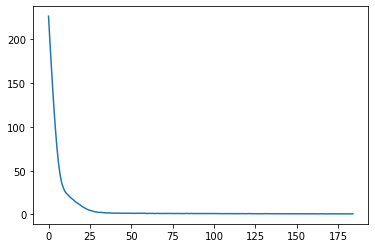

In [44]:
plt.plot(losses)

In [45]:
test_normalized = normalize_data(test_data)

test_target = torch.tensor(test_normalized['close'].values.astype(np.float64))
test = torch.tensor(test_normalized.drop('close', axis = 1).values) 
test_tensor = data_utils.TensorDataset(test, test_target) 
test_loader = data_utils.DataLoader(dataset = test_tensor, batch_size = 32, shuffle = False)


In [46]:
x_labels = list(test_data.index)

13it [00:00, 39.54it/s]


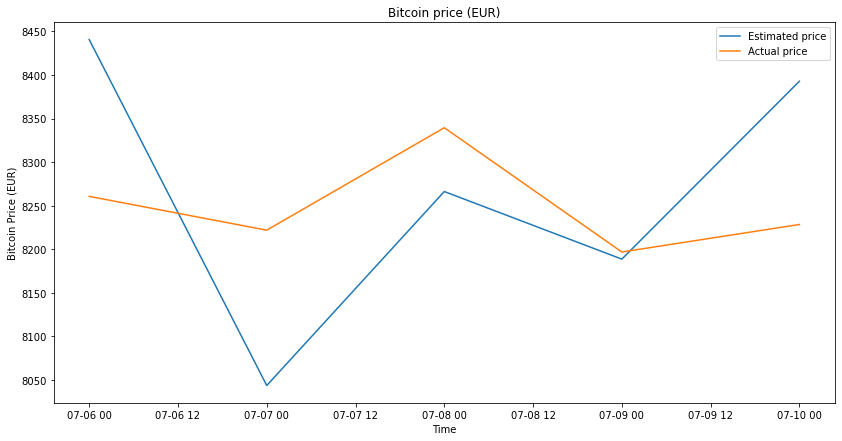

In [80]:
y_list = []
y_hat_list = []
for bidx, batch in tqdm(enumerate(test_loader)):
        X, Y = batch
        for i in range(len(X)):
            x, y = X[i], Y[i]
            x = x.view(-1, len(x))
            y_hat = model(x.float())
            y_list.append(float(y))
            y_hat_list.append(float(y_hat))

#Denormalize the data
min_max_scaler = preprocessing.MinMaxScaler()
min_max_scaler.fit_transform(test_data.values)
vmin = min_max_scaler.data_min_[-1]
vmax = min_max_scaler.data_max_[-1]


y_list = [y_list[i]* (vmax - vmin) + vmin for i in range(len(y_list))]
y_hat_list = [y_hat_list[i]* (vmax - vmin) + vmin for i in range(len(y_hat_list))]

y_df = pd.DataFrame(y_list)
y_df.index = test_data.index

y_hat_df = pd.DataFrame(y_hat_list)
y_hat_df.index = test_data.index


plot_curves([y_hat_df[100:105], y_df[100:105]], ['Estimated price', 'Actual price'], 
            title='Bitcoin price (EUR)', x_label='Time', y_label='Bitcoin Price (EUR)')


In [38]:
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

In [69]:

list(y_hat_df[0])

[5772.014880361818,
 5882.39127343569,
 6467.367530073598,
 6306.9957892178745,
 5995.674022167325,
 5976.482012151145,
 6332.49681987606,
 6323.995911338628,
 6458.229675622433,
 6527.918695233613,
 6532.595698085875,
 6383.630195532069,
 6961.01372680828,
 6442.678560851366,
 5967.072875833921,
 6655.029994713739,
 6285.123120065183,
 6422.9792689110345,
 6328.608773558959,
 6615.083494614289,
 6349.625758509338,
 6677.2681494978815,
 6329.829140519723,
 6718.471413467452,
 6814.2153568990525,
 6836.370726556033,
 7362.427925031781,
 7078.329886474163,
 7397.166455601305,
 7183.065561470837,
 6915.454787602872,
 7029.094324175119,
 6590.461699099765,
 8234.842216513454,
 8052.64446234718,
 8149.895398400724,
 7658.331229772568,
 7950.031583563834,
 8343.405989976525,
 8710.363912094235,
 8708.900542238653,
 8353.58499229312,
 9205.35117436409,
 8269.622139646559,
 8798.372352582217,
 7885.478453328758,
 8668.26589076966,
 9229.098016724289,
 9229.083029761612,
 8611.219087840616,
 90

In [73]:
data = {'realPrice': list(y_df[0]), 'predictPrice': list(y_hat_df[0])}
df_compare = pd.DataFrame(data, index =y_hat_df.index)

In [79]:
df_compare[100:10]

,realPrice,predictPrice
time,,
2020-07-06,8260.60,8423.532359
2020-07-07,8221.77,8406.405115
2020-07-08,8339.43,8966.783350
2020-07-09,8196.71,8229.707933
2020-07-10,8228.30,8101.287148
2020-07-11,8190.74,8551.391490
2020-07-12,8236.33,8288.116230
2020-07-13,8154.94,8409.359688
2020-07-14,8122.69,8256.230575
